## Libraries and data

Podkręcić Bayesa, sprawdzić linear kernel, postarać się o lepszą klasyfikacje poprzez poszukiwanie hiperparametrów. Zmiana sposobu reprezentacji np doctowek
Transformer? Podziałać na poziomie reprezentacji tekstu i klasyfikatora tak aby spróbować osiągnąć lepsze wyniki klasyfikacji. Może jeszcze jeden zbiór danych np reuters. W sprawozdzaniu odnieść się do rezultatów z publikacji -> poszukać

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure

from sklearn.datasets import fetch_20newsgroups

import tensorflow

from clean_text import clean_text
import time

In [3]:
from sklearn.datasets import fetch_20newsgroups
# info about dataset
print(fetch_20newsgroups().DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [10]:
# Prepare data

corpus = fetch_20newsgroups()
categories = fetch_20newsgroups()["target_names"]
train_set = fetch_20newsgroups(subset = 'train', categories = categories)
test_set = fetch_20newsgroups(subset = 'test', categories = categories)

X_train = train_set.data
y_train = train_set.target

X_test = test_set.data
y_test = test_set.target


sample = 32

# show sample of train_set
print("LABEL: {}".format(categories[y_train[sample]]))
print(X_train[sample])


LABEL: sci.electronics
From: xandor@unixg.ubc.ca (John Gilbert )
Subject: Re: Exploding TV!
Organization: The University of British Columbia
Lines: 4
Distribution: usa
NNTP-Posting-Host: unixg.ubc.ca

 Just as a not of possible interest on this subject ..
It is my understanding that exploding televisions were a major cause of
domestic accidents in the Soviet Union in past years!
  



In [11]:
# Clean X_train and X_test
X_train = [clean_text(x_train) for x_train in X_train]
X_test = [clean_text(x_test) for x_test in X_test]


In [33]:
# Show the text cleaner work
cleaned = clean_text(X_train[sample])

print("LABEL: {}".format(categories[y_train[sample]]))
print(cleaned)

LABEL: sci.electronics
from xandor unixg ubc ca john gilbert subject re exploding tv organization the university of british columbia lines number distribution usa nntp posting host unixg ubc ca just as a not of possible interest on this subject it is my understanding that exploding televisions were a major cause of domestic accidents in the soviet union in past years


# Classification by using `CountVectorizer()` and `TfidfTransformer()` as a text representation

### Load data for Naive Bayes

In [3]:
text_clf = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]
)

text_clf = text_clf.fit(X_train, y_train)

## Predict output + confussion matrix

Text(348.209375, 0.5, 'predicted label')

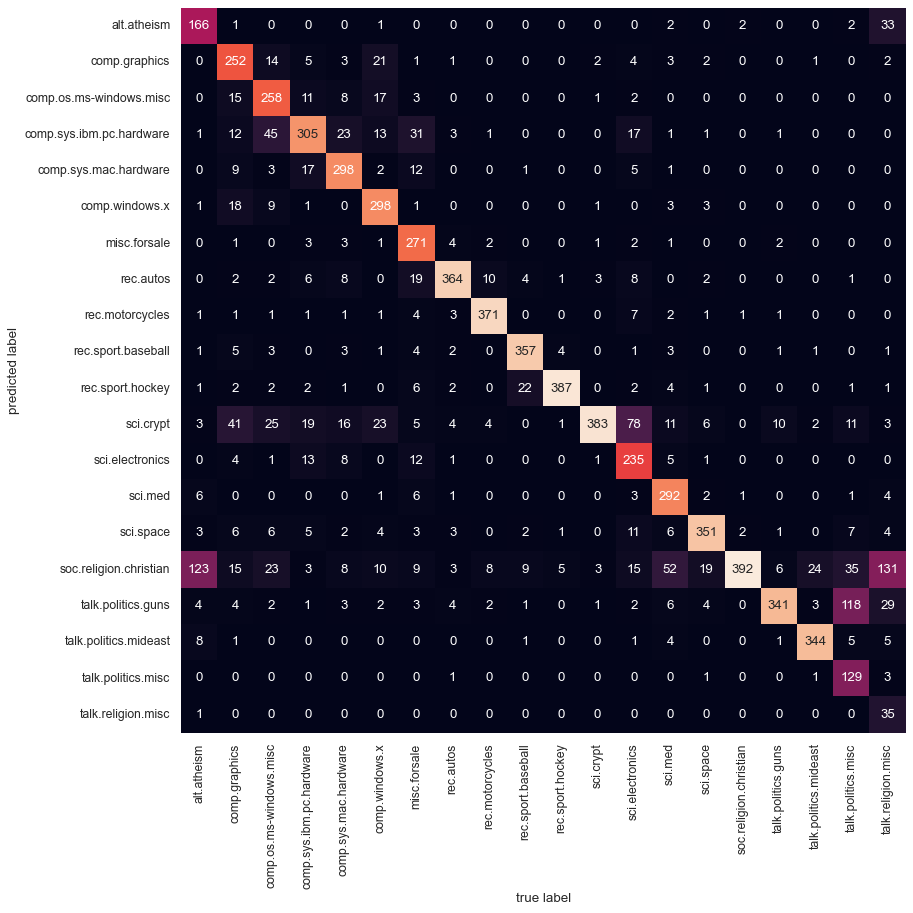

In [7]:
y_pred = text_clf.predict(X_test)

figure(figsize=(18, 12), dpi=80)
x_axis_labels = categories

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square = True, annot=True, fmt = 'd', cbar = False, xticklabels = x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')


## Metrics for Naive Bayes

In [8]:
naive_bayes_accuracy = accuracy_score(y_test, y_pred)
naive_bayes_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Results for Naive Bayes classifier:")
print("Accuracy: {0:.3f} % ".format(naive_bayes_accuracy * 100))
print("Weighted f1 score: {0:.3f}".format(naive_bayes_f1_score))

Results for Naive Bayes classifier:
Accuracy: 77.390 % 
Weighted f1 score: 0.768


# CREATE SVM CLASSIFIER

### Zastosowanie GridSearch w celu znalezienia najlepszych hiperparamterów do wytrenowania modelu

In [5]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              }

all_params = {'linear': {'C': [], 'gamma': [], 'auc': [], 'f1': [], 'time': []},
                'rbf': {'C': [], 'gamma': [], 'auc': [], 'f1': [], 'time': []},
                'poly': {'C': [], 'gamma': [], 'auc': [], 'f1': [], 'time': []},
                'sigmoid': {'C': [], 'gamma': [], 'auc': [], 'f1': [], 'time': []}}

for c_param in param_grid['C']:
    for g_param in param_grid['gamma']:
        for k_param in param_grid['kernel']:
            clf_svm_basic = SVC(C=c_param, gamma=g_param, kernel=k_param)
            text_clf_svm = Pipeline(
                [
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', clf_svm_basic)
                ]
            )

            start_time = time.time()
            text_clf_svm = text_clf_svm.fit(X_train, y_train)
            duration_time = start_time - time.time()

            y_pred = text_clf_svm.predict(X_test)
            svm_basic_accuracy = accuracy_score(y_test, y_pred)
            svm_basic_f1_score = f1_score(y_test, y_pred, average='weighted')

            if k_param == 'linear':
                all_params['linear']['C'].append(c_param)
                all_params['linear']['gamma'].append(g_param)
                all_params['linear']['auc'].append(svm_basic_accuracy)
                all_params['linear']['f1'].append(svm_basic_f1_score)
                all_params['linear']['time'].append(duration_time)

            elif k_param == 'rbf':
                all_params['rbf']['C'].append(c_param)
                all_params['rbf']['gamma'].append(g_param)
                all_params['rbf']['auc'].append(svm_basic_accuracy)
                all_params['rbf']['f1'].append(svm_basic_f1_score)
                all_params['rbf']['time'].append(duration_time)

            elif k_param == 'poly':
                all_params['poly']['C'].append(c_param)
                all_params['poly']['gamma'].append(g_param)
                all_params['poly']['auc'].append(svm_basic_accuracy)
                all_params['poly']['f1'].append(svm_basic_f1_score)
                all_params['poly']['time'].append(duration_time)

            elif k_param == 'sigmoid':
                all_params['sigmoid']['C'].append(c_param)
                all_params['sigmoid']['gamma'].append(g_param)
                all_params['sigmoid']['auc'].append(svm_basic_accuracy)
                all_params['sigmoid']['f1'].append(svm_basic_f1_score)
                all_params['sigmoid']['time'].append(duration_time)
        

In [5]:
param_grid_cleaned = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              }

all_params_cleaned = {'linear': {'C': [], 'gamma': [], 'auc': [], 'f1': [], 'time': []},
                'rbf': {'C': [], 'gamma': [], 'auc': [], 'f1': [], 'time': []},
                'poly': {'C': [], 'gamma': [], 'auc': [], 'f1': [], 'time': []},
                'sigmoid': {'C': [], 'gamma': [], 'auc': [], 'f1': [], 'time': []}}

for c_param in param_grid_cleaned['C']:
    for g_param in param_grid_cleaned['gamma']:
        for k_param in param_grid_cleaned['kernel']:
            clf_svm_basic = SVC(C=c_param, gamma=g_param, kernel=k_param)
            text_clf_svm = Pipeline(
                [
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', clf_svm_basic)
                ]
            )

            start_time = time.time()
            text_clf_svm = text_clf_svm.fit(X_train, y_train)
            duration_time = start_time - time.time()

            y_pred = text_clf_svm.predict(X_test)
            svm_basic_accuracy = accuracy_score(y_test, y_pred)
            svm_basic_f1_score = f1_score(y_test, y_pred, average='weighted')

            if k_param == 'linear':
                all_params_cleaned['linear']['C'].append(c_param)
                all_params_cleaned['linear']['gamma'].append(g_param)
                all_params_cleaned['linear']['auc'].append(svm_basic_accuracy)
                all_params_cleaned['linear']['f1'].append(svm_basic_f1_score)
                all_params_cleaned['linear']['time'].append(duration_time)

            elif k_param == 'rbf':
                all_params_cleaned['rbf']['C'].append(c_param)
                all_params_cleaned['rbf']['gamma'].append(g_param)
                all_params_cleaned['rbf']['auc'].append(svm_basic_accuracy)
                all_params_cleaned['rbf']['f1'].append(svm_basic_f1_score)
                all_params_cleaned['rbf']['time'].append(duration_time)

            elif k_param == 'poly':
                all_params_cleaned['poly']['C'].append(c_param)
                all_params_cleaned['poly']['gamma'].append(g_param)
                all_params_cleaned['poly']['auc'].append(svm_basic_accuracy)
                all_params_cleaned['poly']['f1'].append(svm_basic_f1_score)
                all_params_cleaned['poly']['time'].append(duration_time)

            elif k_param == 'sigmoid':
                all_params_cleaned['sigmoid']['C'].append(c_param)
                all_params_cleaned['sigmoid']['gamma'].append(g_param)
                all_params_cleaned['sigmoid']['auc'].append(svm_basic_accuracy)
                all_params_cleaned['sigmoid']['f1'].append(svm_basic_f1_score)
                all_params_cleaned['sigmoid']['time'].append(duration_time)
        

#### Zapis wyników GridSearch'a do pliku

In [10]:
import csv

with open('output.csv', 'w') as output:
    writer = csv.writer(output)
    for key, value in all_params.items():
        writer.writerow([key, value])

In [7]:
import csv

with open('output_cleaned.csv', 'w') as output:
    writer = csv.writer(output)
    for key, value in all_params_cleaned.items():
        writer.writerow([key, value])

### Najlepsze hiperparametry znalezione przez GridSearch

In [125]:
best_params = {'kernel': '', 'C': 0, 'gamma': 0}

best_f1 = 0
for kernel in all_params:
    for record in all_params[kernel].items():
        if record[0] == 'f1':
            max_val = (max(record[1]))
            max_index = record[1].index(max_val)
            if best_f1 < max_val:
                best_params['kernel'] = kernel
                best_params['C'] =  all_params[kernel]['C'][max_index]
                best_params['gamma'] = all_params[kernel]['gamma'][max_index]
                best_f1 = max_val

print(best_params)

{'kernel': 'rbf', 'C': 100, 'gamma': 0.1}


In [8]:
best_params_cleaned = {'kernel': '', 'C': 0, 'gamma': 0}

best_f1 = 0
for kernel in all_params_cleaned:
    for record in all_params_cleaned[kernel].items():
        if record[0] == 'f1':
            max_val = (max(record[1]))
            max_index = record[1].index(max_val)
            if best_f1 < max_val:
                best_params_cleaned['kernel'] = kernel
                best_params_cleaned['C'] =  all_params_cleaned[kernel]['C'][max_index]
                best_params_cleaned['gamma'] = all_params_cleaned[kernel]['gamma'][max_index]
                best_f1 = max_val

print(best_params_cleaned)

{'kernel': 'rbf', 'C': 10, 'gamma': 0.1}


### Macierz pomyłek (dane nieoczyszczone)

Results for SVM classifier:
Accuracy: 83.696 % 
Weighted f1 score: 0.837


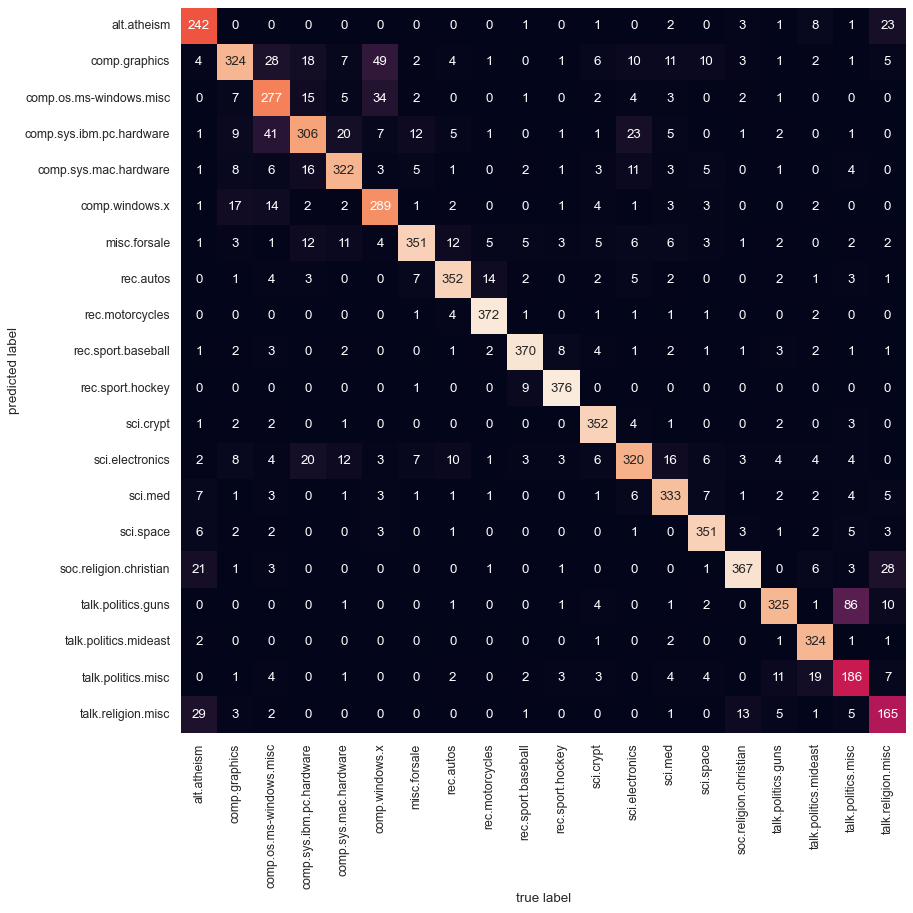

In [9]:
clf_svm_basic = SVC(C=100, gamma=0.1, kernel='rbf')

text_clf_svm = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf_svm_basic)
    ]
)

text_clf_svm = text_clf_svm.fit(X_train, y_train)

y_pred = text_clf_svm.predict(X_test)   

figure(figsize=(18, 12), dpi=80)
x_axis_labels = categories

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square = True, annot=True, fmt = 'd', cbar = False, xticklabels = x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

svm_basic_accuracy = accuracy_score(y_test, y_pred)
svm_basic_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Results for SVM classifier:")
print("Accuracy: {0:.3f} % ".format(svm_basic_accuracy * 100))
print("Weighted f1 score: {0:.3f}".format(svm_basic_f1_score))

### Macierz pomyłek (dane oczyszczone)

In [ ]:
clf_svm_basic = SVC(C=10, gamma=0.1, kernel='rbf')

text_clf_svm = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf_svm_basic)
    ]
)

text_clf_svm = text_clf_svm.fit(X_train, y_train)

y_pred = text_clf_svm.predict(X_test)   

figure(figsize=(18, 12), dpi=80)
x_axis_labels = categories

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square = True, annot=True, fmt = 'd', cbar = False, xticklabels = x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

svm_basic_accuracy = accuracy_score(y_test, y_pred)
svm_basic_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Results for SVM classifier:")
print("Accuracy: {0:.3f} % ".format(svm_basic_accuracy * 100))
print("Weighted f1 score: {0:.3f}".format(svm_basic_f1_score))